# Delta Hedging in the Real World

## 1. Getting the Greeks
The issues is a lot of the real world data is often not include the greeks and they aren't nearly as easy to compute as they were in the binomial model. Our stock also moves in a lot more ways than up or down. Generally in most cases you will have ohlcv bars data available for most options being currently traded. Each of these has a strike, expiration date, type and ohlcv.

### Black Sholes Theory
To calculate the greeks we have to look at Black-Sholes Theory. The basic form of the equations says that the option value $V(s,t)$ satisfies the following:

$  \frac{\partial V}{\partial t} + \frac{1}{2}\,\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r\,S \frac{\partial V}{\partial S} - r\,V = 0  $

This formula suggests that the sum of the options price change with respect to time, the change in price of the underlying, and the change in change of the underlying has to be equal to the riskfree rate times the option value.

### European Options

For european options there are closed form solutions to this equation.

For maturity \(T\) and strike \(K\), the call price \(C(S,t)\) at time \(t\) is

$C(S,t) \;=\; S\,N(d_1)\;-\;K\,e^{-r\,(T-t)}\,N(d_2),$

where $ d_1 \;=\;\frac{\ln\bigl(S/K\bigr) + \bigl(r + \tfrac12\sigma^2\bigr)(T-t)}{\sigma\sqrt{T-t}}, $

$\quad d_2 \;=\; d_1 - \sigma\sqrt{T-t},$ and 

$ N(x) \;=\; \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-u^2/2}\,du$ is the standard normal cumulative distribution function.

**Parameters**

- \(S\): Current price of the underlying asset  
- \(K\): Strike price  
- \(r\): Risk-free interest rate (continuous compounding)  
- \(\sigma\): Volatility of the underlying asset  
- \(t\): Current time (with \(0 \le t \le T\))  
- \(T\): Option maturity date  

### Finding the Volatility $\sigma$

As see in the closed form solution, to calculate any of the values we need to find $\sigma$. For this we will find the roots of the following equation.

Find $\sigma$ s.t. $f(\sigma) = 0$ with $f(\sigma) = C_{calc}(S,K,T,r,\sigma) - C_{actual}$ 

In other words, find the value of $\sigma$ so that the value of the option is equal to its actual value.



In [1]:
from scipy.stats import norm
from scipy.optimize import brentq, newton
import numpy as np

def bs_call_price(S,K,T,r,sigma):
    """Black-Scholes call option price."""
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [2]:
def implied_volatility(S, K, T, r, market_price):
    """Calculate the implied volatility using the Black-Scholes model."""
    def objective_function(sigma):
        return bs_call_price(S, K, T, r, sigma) - market_price
    
    return brentq(objective_function, 1e-6, 5.0,xtol=1e-6)

### Calculating the Greeks

The greeks, based of the close form solution of the Black Sholes equation, are defined like the following:

$\quad\quad\quad\quad \Delta = \frac{\partial V}{\partial S}= N(d_1)$   (Sensitivity to changes in Underlying Price)

$\quad\quad\quad\quad \Gamma = \frac{\partial^2 V}{\partial S^2}  = \frac{N(d_1)}{S\sigma\sqrt{T}}$     (Sensitivity to changes in change rate of Underlying price)

$\quad\quad\quad\quad \nu = \frac{\partial V}{\partial \sigma} =  S N(d_1) \sqrt{T}$ (Sensitivity to Volatility)

$\quad\quad\quad\quad \Theta = -\frac{\partial V}{\partial T} = -\frac{SN(d_1)\sigma}{2\sqrt{T}} - rKe^{-krT}N(d_2)$ (Sensitivity to Time)

$\quad\quad\quad\quad \rho = \frac{\partial V}{\partial r} = \rho = K T e^{-rT} N(d_2)$ (Sensitivity to Interest Rate)

with $ d_1 \;=\;\frac{\ln\bigl(S/K\bigr) + \bigl(r + \tfrac12\sigma^2\bigr)(T-t)}{\sigma\sqrt{T-t}}, $ and $\quad d_2 \;=\; d_1 - \sigma\sqrt{T-t},$  



In [3]:
delta = lambda S, K, T, r, sigma: norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)))
gamma = lambda S, K, T, r, sigma: norm.pdf((np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))) / (S * sigma * np.sqrt(T))
vega =  lambda S, K, T, r, sigma: S * norm.pdf((np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))) * np.sqrt(T)
theta = lambda S, K, T, r, sigma: (-S * norm.pdf((np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)) - sigma * np.sqrt(T)))
rho =   lambda S, K, T, r, sigma: K * T * np.exp(-r * T) * norm.cdf((np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)) - sigma * np.sqrt(T))

## Implementation

For the implementation we need to choose an option that we need to calculate the greeks for. For this case, we will choose the following option based on its data availability and the necessary surrounding options for hedging:

Expiration Date = '2022-06-17'

Option Type= Call

Option Strike = 4500

In [4]:
option_expiration_date = '2022-06-17'
option_type = 'C'
option_strike = 4500.0

### Data History:

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

all_options = pd.read_csv('../data/SPYOPT_processed.csv',index_col=0, parse_dates=['ts_event', 'expiration_date',])
risk_free_rate = pd.read_csv('../data/RFRate.csv',index_col=0, parse_dates=['ts_event'])
futures = pd.read_csv('../data/SPYFUT_processed.csv',index_col=0, parse_dates=['ts_event'])


In [6]:
option_history = all_options.loc[(all_options['expiration_date'] == option_expiration_date) & (all_options['option_type'] == option_type) & (all_options['strike'] == option_strike)].sort_index()
future_history = futures.loc[futures['expiration_date'] == option_expiration_date].sort_index()

annualized_r = 12 *np.log(1 + risk_free_rate['rate']/1200)
annualized_r = annualized_r.to_frame()
annualized_r.index = risk_free_rate.index

annualized_r = annualized_r.sort_index()

beginning_timestamp = option_history.index[0]
end_timestamp = option_history.index[-1]
daily_index = pd.date_range(start=beginning_timestamp, end=end_timestamp, freq='D')

option_history = option_history.reindex(daily_index, method='ffill')
option_history.columns = [f'Option_{col}' for col in option_history.columns]
future_history = future_history.reindex(daily_index, method='ffill')
future_history.columns = [f'Future_{col}' for col in future_history.columns]

annualized_r = annualized_r.reindex(daily_index, method='ffill')
annualized_r.columns = ['Annualized_Rate']
annualized_r.fillna(method='ffill', inplace=True)


all_data = pd.concat([option_history, future_history, annualized_r], axis=1)

all_data = all_data.drop(columns=['Option_open', 'Option_high', 'Option_low', 'Option_volume', 'Future_open', 'Future_high', 'Future_low', 'Future_volume','Future_expiration_date'])
all_data.rename(columns={'Option_close': 'Option_last_price', 'Future_close': 'Future_last_price','Option_expiration_date':'Expiration Date'}, inplace=True)

all_data['Time_to_Expiration'] = (all_data.index[-1] - all_data.index).days / 365

all_data = all_data.iloc[:-1]


/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_57590/1883202195.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  annualized_r.fillna(method='ffill', inplace=True)


In [7]:
all_data['Implied_Volatility'] = all_data.apply(lambda row:implied_volatility(S=row['Future_last_price'],
    K=option_strike,
    T=row['Time_to_Expiration'],
    r=row['Annualized_Rate'],
    market_price=row['Option_last_price']), axis=1)

In [8]:
deltas = all_data.apply(lambda row: delta(S=row['Future_last_price'],
    K=option_strike,
    T=row['Time_to_Expiration'],
    r=row['Annualized_Rate'],
    sigma=row['Implied_Volatility']), axis=1)   
gammas = all_data.apply(lambda row: gamma(S=row['Future_last_price'],
    K=option_strike,
    T=row['Time_to_Expiration'],            
    r=row['Annualized_Rate'],
    sigma=row['Implied_Volatility']), axis=1)
vegas = all_data.apply(lambda row: vega(S=row['Future_last_price'],
    K=option_strike,
    T=row['Time_to_Expiration'],
    r=row['Annualized_Rate'],
    sigma=row['Implied_Volatility']), axis=1)
thetas = all_data.apply(lambda row: theta(S=row['Future_last_price'],
    K=option_strike,
    T=row['Time_to_Expiration'],
    r=row['Annualized_Rate'],
    sigma=row['Implied_Volatility']), axis=1)
rhos = all_data.apply(lambda row: rho(S=row['Future_last_price'],
    K=option_strike,
    T=row['Time_to_Expiration'],
    r=row['Annualized_Rate'],   
    sigma=row['Implied_Volatility']), axis=1)


greeks = pd.DataFrame({
    'Delta': deltas,
    'Gamma': gammas,    
    'Vega': vegas,
    'Theta': thetas,
    'Rho': rhos
}, index=all_data.index)


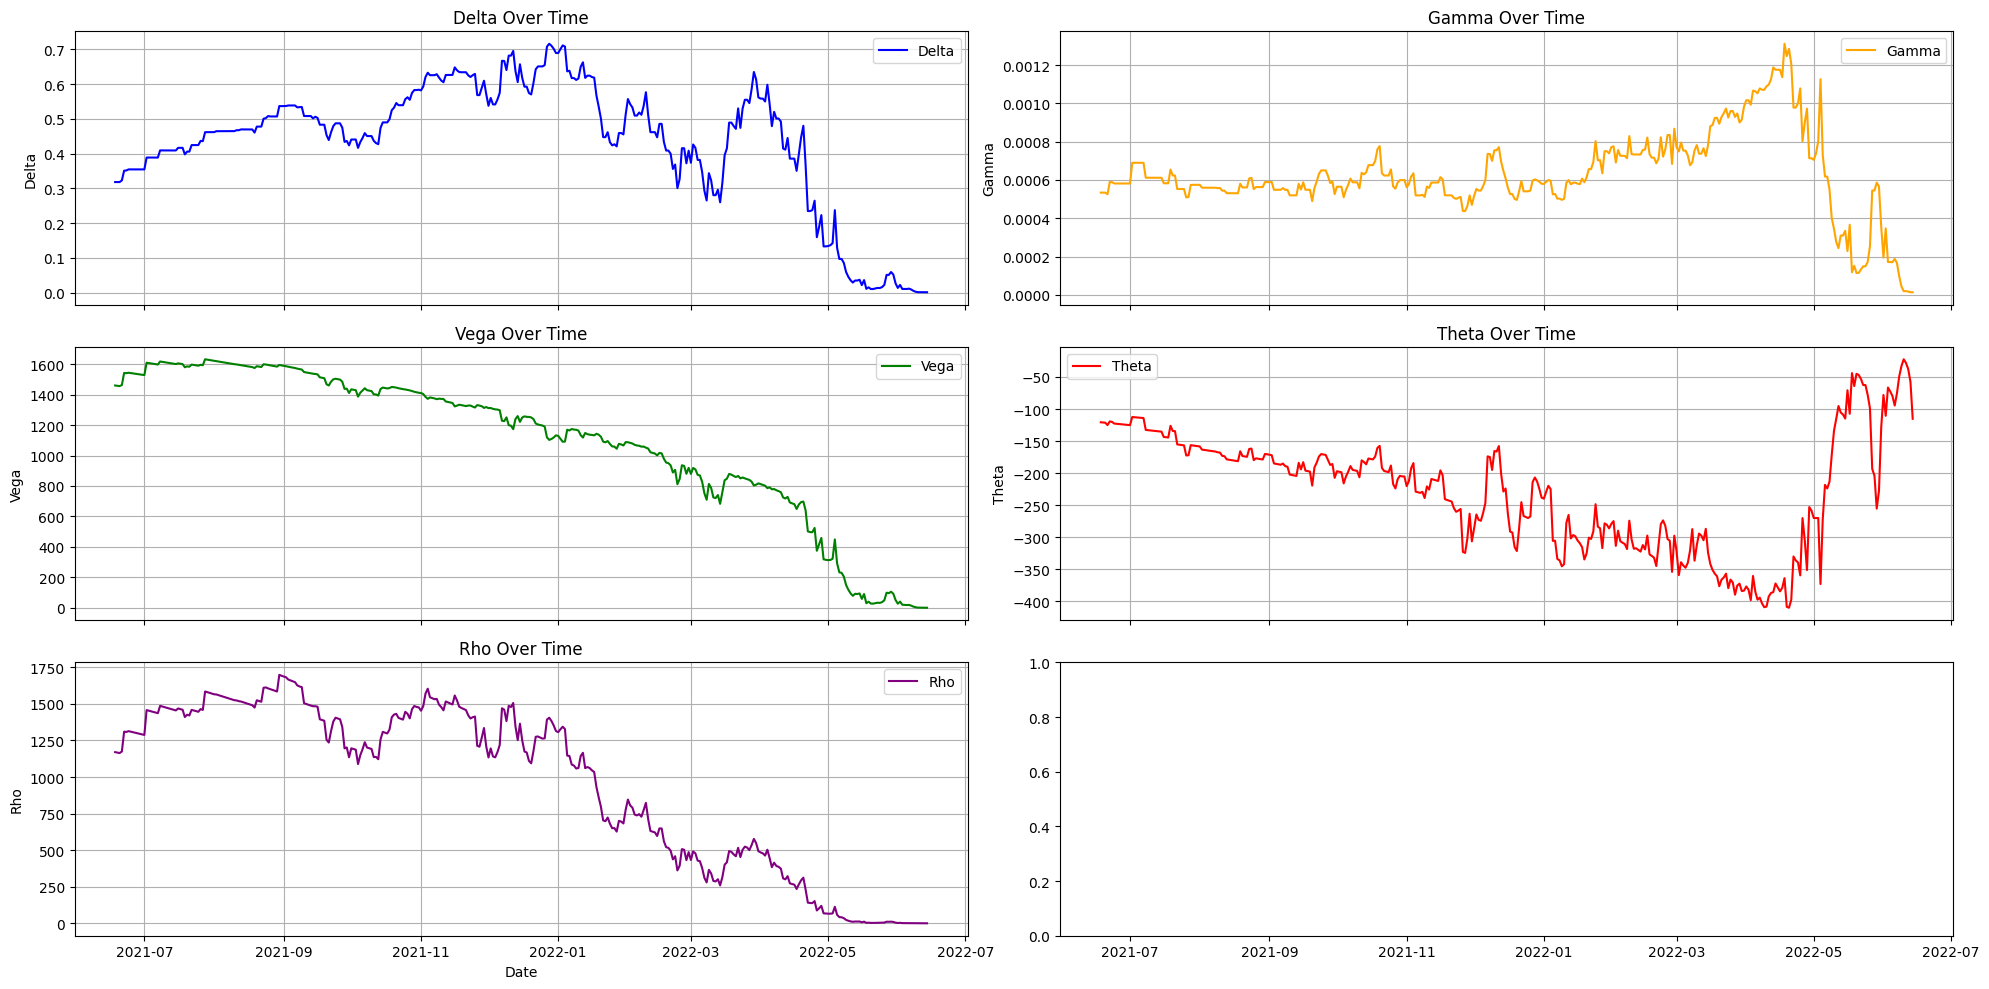

In [14]:
fix,axs = plt.subplots(3,2 , figsize=(20, 10), sharex=True)
axs[0,0].plot(greeks.index, greeks['Delta'], label='Delta', color='blue')
axs[0,0].set_title('Delta Over Time')
axs[0,0].set_ylabel('Delta')
axs[0,0].legend()
axs[0,0].grid()       
axs[0,1].plot(greeks.index, greeks['Gamma'], label='Gamma', color='orange')
axs[0,1].set_title('Gamma Over Time')
axs[0,1].set_ylabel('Gamma')
axs[0,1].legend()
axs[0,1].grid()
axs[1,0].plot(greeks.index, greeks['Vega'], label='Vega', color='green')
axs[1,0].set_title('Vega Over Time')
axs[1,0].set_ylabel('Vega')
axs[1,0].legend()
axs[1,0].grid()
axs[1,1].plot(greeks.index, greeks['Theta'], label='Theta', color='red')
axs[1,1].set_title('Theta Over Time')
axs[1,1].set_ylabel('Theta')
axs[1,1].legend()
axs[1,1].grid()
axs[2,0].plot(greeks.index, greeks['Rho'], label='Rho', color='purple')
axs[2,0].set_title('Rho Over Time')
axs[2,0].set_ylabel('Rho')
axs[2,0].legend()
axs[2,0].grid()
axs[2,0].set_xlabel('Date')
plt.tight_layout()
plt.savefig('../assets/real_world_greeks.png')
plt.show()

### Delta Hedging

Now that we have the Greeks all calculated, we can now proceed to delta hedge this option+stock+cash portfolio.

The first step is to delta hedge assuming there are no trading costs and no delay, so we will delta hedge at each time point (daily)



In [10]:
asset_prices = all_data['Future_last_price']
option_prices = all_data['Option_last_price']
deltas = greeks['Delta']

future_position = -deltas
trades = future_position.diff().fillna(future_position)
cashflow = - (trades * asset_prices)
cashflow.at[cashflow.index[0]] -= option_prices.iloc[0]  # Initial cash outflow for buying the option
cash_cum  = cashflow.cumsum()

portfolio_value = option_prices + (future_position * asset_prices) + cash_cum

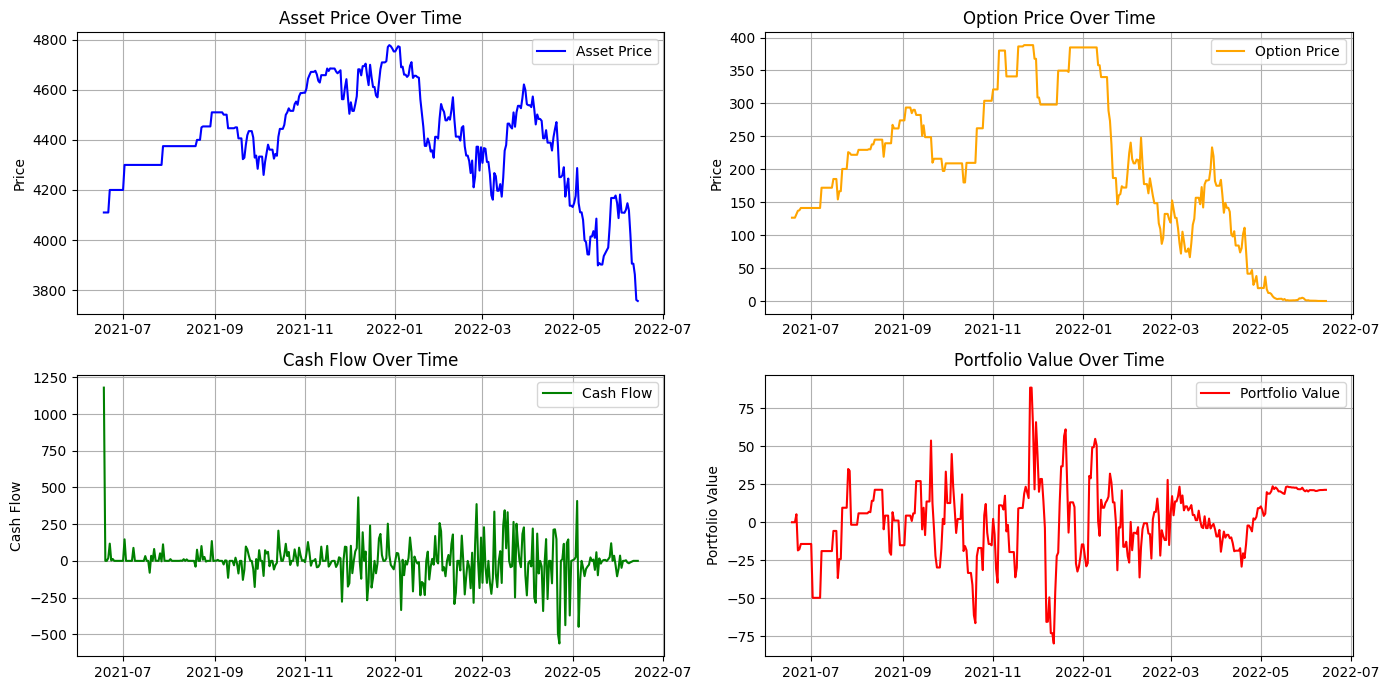

In [15]:
fig, ax1 = plt.subplots(figsize=(14, 7),ncols=2,nrows=2)

ax1[0,0].plot(asset_prices.index, asset_prices, label='Asset Price', color='blue')
ax1[0,0].set_title('Asset Price Over Time')
ax1[0,0].set_ylabel('Price')
ax1[0,0].legend()
ax1[0,0].grid() 

ax1[0,1].plot(option_prices.index, option_prices, label='Option Price', color='orange')
ax1[0,1].set_title('Option Price Over Time')
ax1[0,1].set_ylabel('Price')
ax1[0,1].legend()
ax1[0,1].grid()


ax1[1,0].plot(cashflow.index, cashflow, label='Cash Flow', color='green')
ax1[1,0].set_title('Cash Flow Over Time')
ax1[1,0].set_ylabel('Cash Flow')
ax1[1,0].legend()
ax1[1,0].grid()

ax1[1,1].plot(portfolio_value.index, portfolio_value, label='Portfolio Value', color='red')
ax1[1,1].set_title('Portfolio Value Over Time')
ax1[1,1].set_ylabel('Portfolio Value')
ax1[1,1].legend()
ax1[1,1].grid()

fig.tight_layout()
fig.savefig('../assets/real_world_portfolio.png')
    



As the future price rises over time, the options price indirectly follows it. The options premium strongly increases and decreases depending on volatility and the moneyness.

The cashflow also resembles follows the same trend. A big spike at $t_0$ to represent the initial position taking, and then the movement of cash follows the volatility.

The portfolio movements as well oscillates around 0. This is what is supposed to since we ideally perfectly hedged our position. The oscillation comes from strong market moves and gamma. To get rid of these strong movements you will need to gamma hedge your portfolio.

## Implied vs. Realized Volatility

As found in literature, if the implied volatility is under the realized volatility, you can profit of delta hedging. This means that your options will be underpriced and will adjust. In the following we will take a look at the evolution of implied and realized volatility.

The implied volatility is derived through the option price. The realized volatility is calculated by taking the standard deviations of log returns from the time point until expiry and annualizing it to make it useable for comparison.


In [12]:
import numpy as np
import pandas as pd

returns = np.log(asset_prices).diff()            # r_i = ln(S_t / S_{t-1})
returns = returns.dropna()  # Drop the first NaN value

realized_vol = []

for i in range(len(returns)):
    realized_vol.append(np.std(returns[i:]) * np.sqrt(252))  # Annualize the volatility

realized_vol = pd.Series(realized_vol, index = returns.index, name='Realized_Volatility')

/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_57590/321559696.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


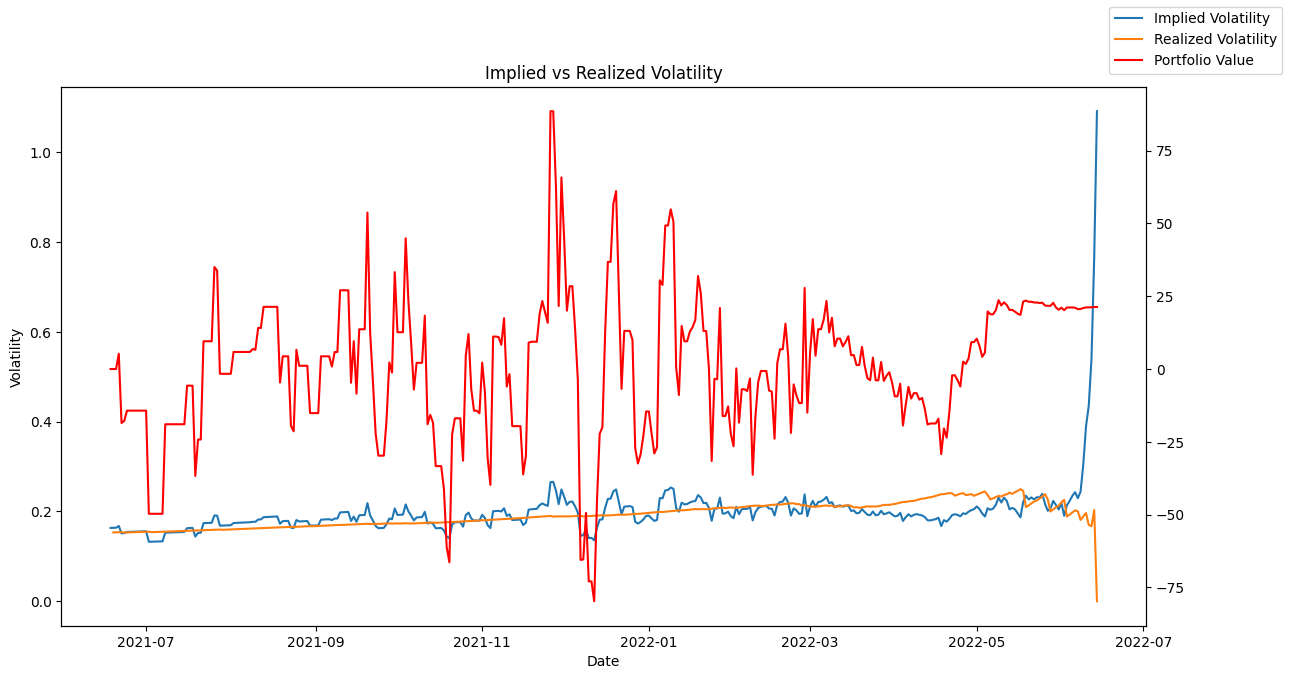

In [16]:
fig,axs1 = plt.subplots(figsize=(14, 7))
axs1.plot(all_data.index, all_data['Implied_Volatility'], label='Implied Volatility')
axs1.plot(realized_vol.index, realized_vol, label='Realized Volatility')
axs1.set_xlabel('Date')
axs1.set_ylabel('Volatility')
axs1.set_title('Implied vs Realized Volatility')

axs2 = axs1.twinx()
axs2.plot(portfolio_value.index, portfolio_value, label='Portfolio Value',color = 'red')

fig.legend()
fig.savefig('../assets/real_world_volatility.png')
fig.show()